# image segmentation algorithm
- k-means clustering
- anisotropic segmentation
- watershed segmentation


In [19]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from util_func import *
import scipy

ModuleNotFoundError: No module named 'scipy'

In [20]:
pip install spicy scikit-learn

                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.2/9.2 MB 2.0 MB/s eta 0:00:05
     -                                        0.3/9.2 MB 2.4 MB/s eta 0:00:04
     -                                        0.4/9.2 MB 2.0 MB/s eta 0:00:05
     -                                        0.4/9.2 MB 2.0 MB/s eta 0:00:05
     -                                        0.5/9.2 MB 1.8 MB/s eta 0:00:05
     --                                       0.5/9.2 MB 1.7 MB/s eta 0:00:06
     --                                       0.5/9.2 MB 1.6 MB/s eta 0:00:06
     --                                       0.6/9.2 MB 1.5 MB/s eta 0:00:06
     --                                       0.6/9.2 MB 1.5 MB/s eta 0:00:06
     --                                       0.7/9.2 MB 1.4 MB/s eta 0:00:06
     ---                                      0.7/9.2 MB 1.4 MB/s eta 0:00:07



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# simple demo of k-mean clustering
- steps:
1) sample gaussian distribution
2) mean covariance
3) perform k-mean

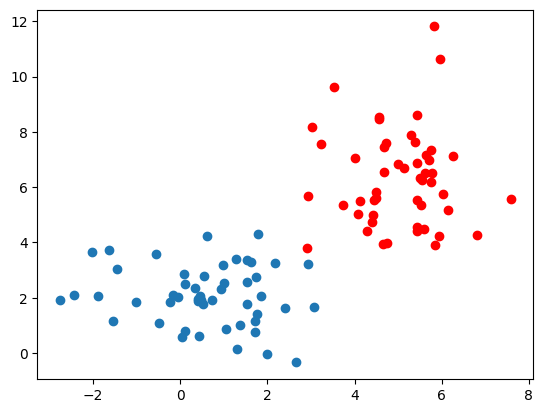

In [3]:
np.random.seed(2)
#define bivariate Gaussian distribution function and sample
mean1 = (1,2)
cov1 = np.array([[2,0],[0,1]])
dat1 = np.random.multivariate_normal(mean1,cov1,size=50)

#cluster2
mean2 = (5,6)
cov2 = np.array([[1,0],[0,2]])
dat2 = np.random.multivariate_normal(mean2,cov2,size=50)


#concatenante dat1 & dat2 into 1 array
data = np.concatenate((dat1,dat2),axis=0)

plt.scatter(dat1[:,0],dat1[:,1])
plt.scatter(dat2[:,0],dat2[:,1],c="r")
plt.show()

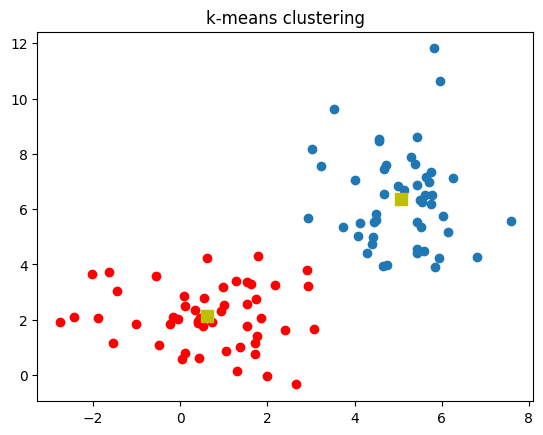

In [4]:
#k-means clustering: sk learn, cv
criteria = (cv.TERM_CRITERIA_EPS +cv.TERM_CRITERIA_MAX_ITER,10,1.0)

#input data should  be float32
Z = np.float32(data)
                                #number of cluster,iteration
ret, label, center = cv.kmeans(Z,2,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

#subset the data with label 0 and 1
A = Z[label.ravel() ==0 ]
B = Z[label.ravel() ==1 ]

plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c="r")
plt.scatter(center[:,0],center[:,1],c="y",s=80,marker="s")
plt.title("k-means clustering")
plt.show()

In [5]:
np.unique(label)

array([0, 1], dtype=int32)

In [6]:
label.shape

(100, 1)

# demo on image

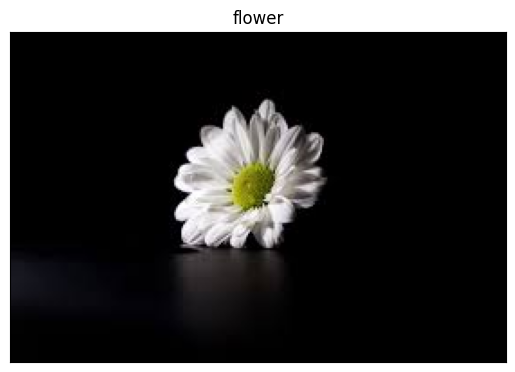

In [7]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img,cv.COLOR_BGR2RGB)

plt_img(img_rgb,"flower")

In [8]:
def k_means_clust(img,K,max_iter=10,eps=1.0,attempts=10,flag=cv.KMEANS_PP_CENTERS):
    """Args
    img:color image (3 channel)
    K=number of clusters
    by default, max_iter=10,eps1,attempts=10,k-means++"""

    #reshape array into matrix
    img = img.reshape((-1,3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS +cv.TERM_CRITERIA_MAX_ITER,10,1.0)
    return cv.kmeans(img,K,None,criteria,attempts,flag)

ret, label, center = k_means_clust(img_rgb,3)

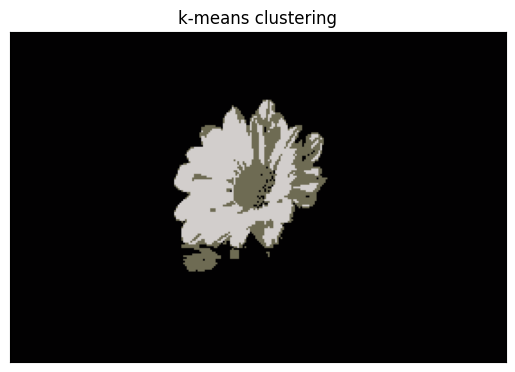

In [9]:
#propagate the center back into the quantize image
#set center
center = np.uint8(center)

res = center[label.flatten()]
quant = res.reshape(img_rgb.shape)

plt_img(quant,"k-means clustering")

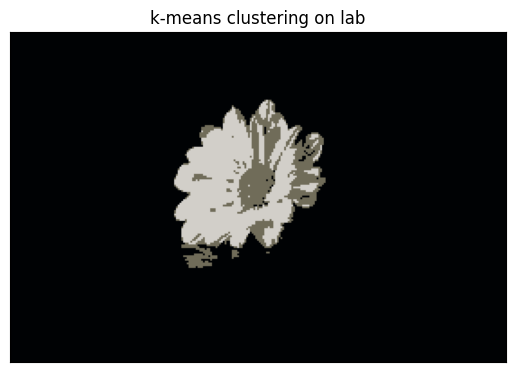

In [10]:
# lab is the best (some experts said) because of the perceptual uniformity
img = cv.imread("images/flower.jfif")
img_lab = cv.cvtColor(img,cv.COLOR_BGR2LAB)
# plt_img(img_lab,"flower")

ret, label, center = k_means_clust(img_lab,3)

center = np.uint8(center)

res = center[label.flatten()]
quant = res.reshape(img_lab.shape)

#when present the lab need to change lab to rgb
quant_rgb = cv.cvtColor(quant,cv.COLOR_LAB2RGB)

plt_img(quant_rgb,"k-means clustering on lab")

# Anisotropic Segmentation

In [11]:
def calcGST(inputIMG, w,method_edge="scharr"):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if method_edge == "scharr":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    elif method_edge == "sobel":
        imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1)
    else:
        raise Exception("no  ")
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut 

can use 'cv.Gaussian()' in line 18-20, instead of 'cv.boxFilter()'. But have to keep in mind of the zero division problem in line 36. Add small consatnt on denominator.

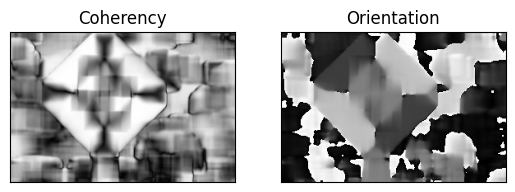

In [12]:
img = cv.imread("images/traffic_sign.jfif")
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
blur= cv.GaussianBlur(gray,(5,5),0)

W = 25
imgCoherency, imgOrientation = calcGST(blur,W)

#normalize coherency and orientation
imgCoherency_norm = cv.normalize(imgCoherency,None,alpha=0, beta=1,norm_type=cv.NORM_MINMAX,dtype=cv.CV_32F)

imgOrientation_norm = cv.normalize(imgOrientation,None,alpha=0, beta=1,norm_type=cv.NORM_MINMAX,dtype=cv.CV_32F)

plt.subplot(121),plt_img(imgCoherency_norm,"Coherency")
plt.subplot(122),plt_img(imgOrientation_norm,"Orientation")
plt.show()

In [11]:
#set up trackbars that control threshold for coherency and oriantation map
def nothing(x):
    pass

wn = "Anisotropic segmentation"

cv.namedWindow(wn,cv.WINDOW_NORMAL | cv.WINDOW_FREERATIO)

cv.createTrackbar("CoHERENCY THRESHOLD 1",wn,50,100,nothing)
cv.createTrackbar("C0HERENCY THRESHOLD 2",wn,70,100,nothing)
cv.createTrackbar("Orientation THRESHOLD 1",wn,50,180,nothing)
cv.createTrackbar("Orientation THRESHOLD 2",wn,100,180,nothing)

img = cv.imread("images/traffic_sign.jfif")
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
blur= cv.GaussianBlur(gray,(5,5),0)

W=27
imgCoherency,imgOrientation = calcGST(blur,W)

while(1):
    th_C_1 = cv.getTrackbarPos("Coherency threshold 1",wn) *0.01
    th_C_2 = cv.getTrackbarPos("Coherency threshold 2",wn)*0.01
    th_Or_1 = cv.getTrackbarPos("Orientation threshold 1",wn)
    th_Or_2 = cv.getTrackbarPos("Orientation threshold 2",wn)
    
    #perform  thresholding
    imgBin_C_1 = cv.threshold(imgCoherency,th_C_1,255,cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency,th_C_2,255,cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation,th_Or_1,255,cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation,th_Or_2,255,cv.THRESH_BINARY_INV)[1]
    
    #merge the pairs of coherency binary and orientation binary
    imgbin_C = cv.bitwise_and(imgBin_C_1,imgBin_C_2)
    imgbin_Or = cv.bitwise_and(imgBin_Or_1,imgBin_Or_2)
    
    #final mask
    imgBin = cv.bitwise_and(imgBin_C,imgBin_Or)
    
    #print segmentation result
    mask = imgBin != 0
    res = img*(mask[:,:,None].astype(np.uint8))
    cv.imshow(wn,res)
    cv.imshow("segmentation mask",imghBin)
    
    k = cv.waitKey(1) &0xFF
    if k==27:
        break
        
cv.destroyAllWindow()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:866: error: (-215:Assertion failed) trackbar in function 'cv::getTrackbarPos'


# watershed segmentation on traffic sign images

In [13]:
img = cv.imread("images/traffic_sign.jfif")

show_img("img",img)

In [14]:
#gaussian bluring
blur = cv.GaussianBlur(img,(5,5),0)
#mean shift segmentation
blur = cv.pyrMeanShiftFiltering(blur,15,20,maxLevel=2)

show_img("mean shift",blur)

In [15]:
#change to gray scale
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

#morphological gradient(edge, local maximum)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(11,11))
loc_grad = cv.morphologyEx(gray,cv.MORPH_GRADIENT,kernel,iterations=2)

show_img("gradient",loc_grad)

In [16]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed

ModuleNotFoundError: No module named 'scipy'

In [17]:
#th
th = loc_grad < 80 #boolean
s = np.ones((3,3),dtype=int)
marker = ndi.label(th,structure=s)[0]

plt.imshow(marker,cmap="jet")
plt.show()

NameError: name 'ndi' is not defined

In [18]:
#topographic surface
edge = cv.Canny(gray,250,500)

labels = watershed(edge,marker)

np.unique(labels,return_counts=True)

NameError: name 'watershed' is not defined

In [ ]:
plt.figure()

gray_ori = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori,cmap="gray")
plt.imshow(labels,cmap=plt.cm.nipy_spectral,alpha=.5)
plt.colorbar()
plt.show()

In [ ]:
label_vec, counts = np.unique(labels,return_counts=True)

label_bg = label_vec[np.argmax(counts)]

mask = 255*np.ones(labels.shape,dtype=np.uint8)

mask[labels==label_bg]=0

#find contour
contours,_ = cv.findContours(mask,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

#find the largest cintour
contour = sorted(contours, key=cv.contourArea,reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy,[contour],-1,(0,255,0),2)

show_img("watershed",img_copy)

In [ ]:
label_bg

In [ ]:
#example 4

In [ ]:
img = cv.imread("images/traffic_sign1.jpg")
(h, w) = img.shape[:2]
blur = cv.GaussianBlur(img, (5, 5), 0)

In [ ]:
# Convert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2Lab)

img_lab = img_lab.reshape((h*w, 3))
img_lab = np.float32(img_lab)
# criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_PP_CENTERS

compactness, labels, centers = cv.kmeans(img_lab, 10, None, criteria, 10, flags)

quant = centers.astype(np.uint8)[labels]
quant = quant.reshape((h, w, 3))

bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("kmeans quantization", bgr)

In [ ]:
img_lab[..., 0].min()

In [ ]:
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

show_img("threshold", th)

In [ ]:
from skimage.feature import peak_local_max

In [ ]:
kernel = np.ones((3, 3), dtype=np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=3)

dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)

coords = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=th)

mask = np.zeros(dist_transform.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-dist_transform, markers, mask=th)

In [ ]:
plt.imshow(labels, cmap=plt.cm.jet)
plt.colorbar(), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
label_vec, counts = np.unique(labels,return_counts=True)

label_bg = label_vec[np.argmax(counts)]

mask = 255*np.ones(labels.shape,dtype=np.uint8)

mask[labels==label_bg]=0

#find contour
contours,_ = cv.findContours(mask,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

#find the largest cintour
contour = sorted(contours, key=cv.contourArea,reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy,[contour],-1,(0,255,0),2)

show_img("watershed",img_copy)

In [ ]:
#bounding box just get the contour
img_copy = img.copy()

x,y,w,h = cv.boundingRect(contour)
cv.rectangle(img_copy,(x,y),(x+w,x+h),(0,255,0),2)

show_img("bounding box",img_copy)

In [21]:
#weekly activity 
image = cv.imread('zebra.jfif')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image.reshape((-1, 3))

# Color space names and corresponding conversion codes
color_spaces = ['BGR', 'HSV', 'LAB']
conversion_codes = [cv.COLOR_RGB2BGR, cv.COLOR_RGB2HSV, cv.COLOR_RGB2LAB]

# Initialize the plot
plt.figure(figsize=(12, 8))

for i, color_space in enumerate(color_spaces):
    plt.subplot(1, 3, i + 1)
    plt.title(color_space)

    converted_image = cv.cvtColor(image, conversion_codes[i])
    converted_pixels = converted_image.reshape((-1, 3))

    wcss_values = []

    # Apply k-means clustering for different values of k
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(converted_pixels)
        wcss_values.append(kmeans.inertia_)

    # Plot the WCSS vs. number of clusters
    plt.plot(range(2, 11), wcss_values, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares')

plt.tight_layout()
plt.show()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
